# Machine Learning Tracking with Mlflow

## Credit Card Fraud Detection Problem

- Datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

- The data contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. 

- Input Features: V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. 

- Output: 1 in case of fraud and 0 otherwise.
- Link to the dataset: https://www.kaggle.com/mlg-ulb/creditcardfraud/home

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# import data
creditcard_df = pd.read_csv("creditcard.csv")

In [3]:
creditcard_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Data dimensions
print(f'Number of Rows: {len(creditcard_df)}')
print(f'Number of cloumns: {creditcard_df.shape[1]}')

Number of Rows: 284807
Number of cloumns: 31


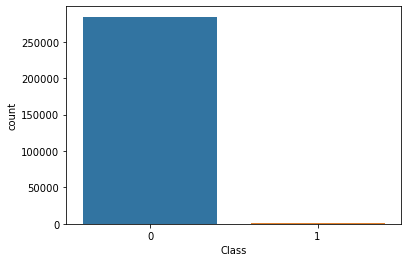

In [5]:
# Target distribution 
# Data is extremely unbalanced
sns.countplot(x = creditcard_df['Class'], label = "Count") ;

In [6]:
fraud_percent = np.round(creditcard_df['Class'].sum()/len(creditcard_df),4)
print(f'fraud transactions percentage = {fraud_percent}%')

fraud transactions percentage = 0.0017%


In [7]:
# checking for any missing values
creditcard_df.isna().any()

Time      False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10       False
V11       False
V12       False
V13       False
V14       False
V15       False
V16       False
V17       False
V18       False
V19       False
V20       False
V21       False
V22       False
V23       False
V24       False
V25       False
V26       False
V27       False
V28       False
Amount    False
Class     False
dtype: bool

## Machine Learning Models

In [8]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [9]:
import mlflow
import mlflow.sklearn

In [10]:
# train test split
train_x, test_x, train_y, test_y = train_test_split(creditcard_df.drop('Class', axis = 1), creditcard_df['Class'], 
                                                    stratify = creditcard_df['Class'],
                                                    test_size = 0.3,
                                                    random_state = 99)

In [11]:
print("Train Data size")
print(train_x.shape, train_y.shape)
print("Test Data Size")
print(test_x.shape, test_y.shape)

Train Data size
(199364, 30) (199364,)
Test Data Size
(85443, 30) (85443,)


In [12]:
# set the experiment name for mlflow tracking
mlflow.set_experiment("Mflow Tutorial")

INFO: 'Mflow Tutorial' does not exist. Creating a new experiment


### Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [14]:
lr_model = LogisticRegression(class_weight='balanced') # using class_weight as 'balanced' to handle classs imbalance
lr_pipeline = Pipeline(steps=[('normalize',StandardScaler()), 
                              ('LR',lr_model)])

In [15]:
lr_param_grid = {'LR__C': np.logspace(-4, 4, 4)}

In [16]:
# mlflow auto tracking
mlflow.sklearn.autolog()

In [17]:
with mlflow.start_run(run_name="Logistic Regression"):
  lr_search = GridSearchCV(lr_pipeline, param_grid=lr_param_grid, scoring='roc_auc', n_jobs=-1)
  lr_search.fit(train_x, train_y)

  print(f'Best CV Score: {lr_search.best_score_}')
  print(f'Best parameters: {lr_search.best_params_}')

  # test score
  test_pred = lr_search.predict_proba(test_x)
  test_auc = roc_auc_score(test_y, test_pred[:,1])
  #log test metrics
  mlflow.log_metric("Test_AUC", test_auc)
  print(f'Test AUC: {np.round(test_auc,3)}')

Best CV Score: 0.9747445646498193
Best parameters: {'LR__C': 0.0001}
Test AUC: 0.991


### Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
rf_model = RandomForestClassifier(class_weight = 'balanced_subsample', random_state =99)
rf_param = {'n_estimators': [100,200],
            'max_depth':[3,5,7]}

In [25]:
# mlflow auto tracking
mlflow.sklearn.autolog()

with mlflow.start_run(run_name="Randm Forest"):
  rf_search = GridSearchCV(rf_model, param_grid=rf_param, scoring='roc_auc', n_jobs=-1)
  rf_search.fit(train_x, train_y)

  print(f'Best CV Score: {rf_search.best_score_}')
  print(f'Best parameters: {rf_search.best_params_}')

  # test score
  test_pred = rf_search.predict_proba(test_x)
  test_auc = roc_auc_score(test_y, test_pred[:,1])
  #log test metrics
  mlflow.log_metric("Test_AUC", test_auc)
  print(f'Test AUC: {np.round(test_auc,3)}')

Best CV Score: 0.9787661619942835
Best parameters: {'max_depth': 7, 'n_estimators': 200}
Test AUC: 0.989


After Running the models and tracking them, we can see the results by running command *mlflow ui* from terminal  

We can see somthing like below in the ui.

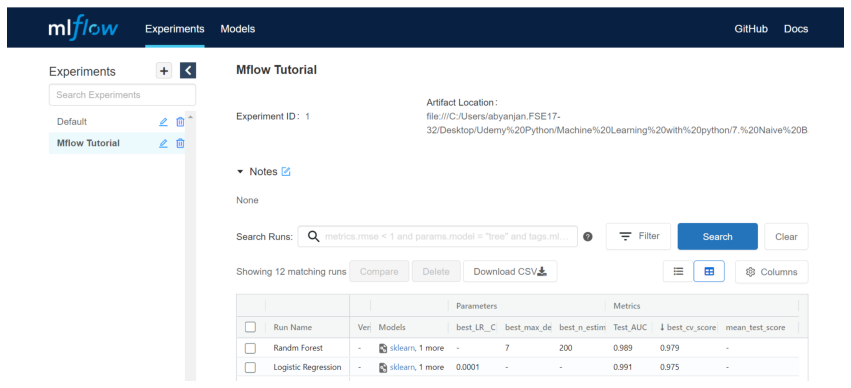

In [34]:
img = plt.imread('ui.png')
plt.figure(figsize = (15,8))
plt.imshow(img);
plt.axis('off');

mlflow autolog also saves the model artificats and some evaluation plots, including confusion matrix, auc curve and pr-auc curve.

**Showing Results for Logistic Regression**

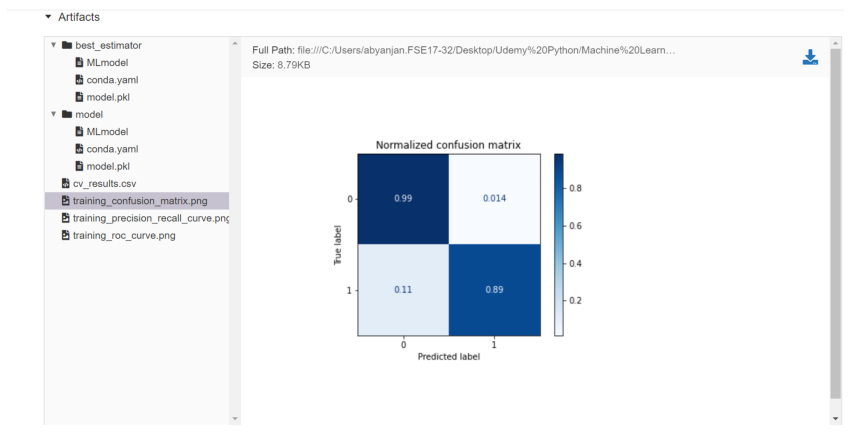

In [36]:
# confusion matrix
cf_img = plt.imread('cf_matrix.png')
plt.figure(figsize = (15,8))
plt.imshow(cf_img);
plt.axis('off');

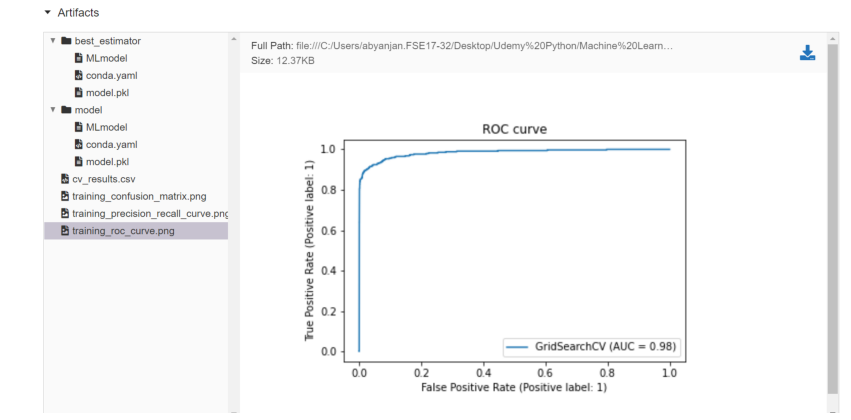

In [37]:
# AUC Curve
auc_img = plt.imread('auc-curve.png')
plt.figure(figsize = (15,8))
plt.imshow(auc_img);
plt.axis('off');

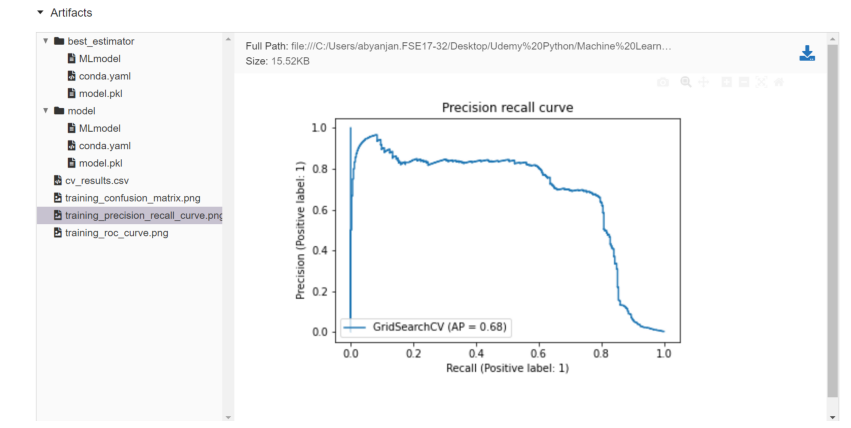

In [39]:
#pr-auc curve
pr_img = plt.imread('pr-curve.png')
plt.figure(figsize = (15,8))
plt.imshow(pr_img);
plt.axis('off');

### Making Prediction

With model artifacts being saved with mlflow, we can simply load the best model and make predictions.

In [40]:
# load logistic regression model
logged_model = 'file:///C:/Users/abyanjan.FSE17-32/Desktop/Udemy%20Python/Machine%20Learning%20with%20python/7.%20Naive%20Bayes/mlruns/1/d74c738ff77b4644a3be0b9c56580fda/artifacts/model'
model = mlflow.pyfunc.load_model(logged_model)

In [53]:
# making predictions on few rows of test data
data = test_x.head(20)
target = test_y.head(20)

In [54]:
predictions = model.predict(data)

In [55]:
# display the results, acutal and predictions
results = pd.DataFrame({'Actual_label':target, 'Predictions':predictions}).reset_index(drop = True)
results

,Actual_label,Predictions
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0
